In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action = 'ignore')

import pandas as pd
import numpy as np
from datetime import datetime

# 시각화
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install missingno
import missingno as msno

# 한글깨짐 문제 해결
font_path = 'C:/Windows/Fonts/NGULIM.TTF'
font_name = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font_name)

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# !pip install --upgrade pip

from tslearn.metrics import soft_dtw
from tslearn.clustering import TimeSeriesKMeans

from lightgbm import LGBMRegressor
# ! pip install catboost
from catboost import CatBoostRegressor

In [2]:
train = pd.read_csv('electric_train.csv', encoding='CP949')
# train.drop(columns=['Unnamed: 0'], inplace=True)
train.columns = [col.replace('electric_train.', '') for col in train.columns]
train.drop(columns=['sum_qctr', 'n', 'sum_load', 'n_mean_load'], inplace=True)
train['tm'] = pd.to_datetime(train['tm'])
train.head()
# num : 격자넘버, stn : 지점 번호

,num,tm,hh24,stn,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi,weekday,week_name,elec
0,4821,2021-01-01 01:00:00,1,884,2.2,62.7,1.8,0.0,-1.0,4,0,99.56
1,4821,2021-01-01 02:00:00,2,884,2.3,63.1,2.1,0.0,-0.6,4,0,91.78
2,4821,2021-01-01 03:00:00,3,884,2.2,62.4,2.5,0.0,-1.3,4,0,79.17
3,4821,2021-01-01 04:00:00,4,884,1.7,63.5,1.7,0.0,-0.2,4,0,73.34
4,4821,2021-01-01 05:00:00,5,884,1.7,63.0,1.6,0.0,-0.8,4,0,69.73


In [3]:
test_df = pd.read_csv('electric_test.csv', encoding='CP949')
# test_df.drop(columns=['Unnamed: 0'], inplace=True)
test_df.columns = [col.replace('electric_test.', '') for col in test_df.columns]
test_df.head()

,NUM,TM,HH24,STN,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi,weekday,week_name,elect
0,4816,2023-01-01 01:00:00,1,752,3.0,68.6,2.9,0.0,-0.1,6,1.0,NaN
1,4816,2023-01-01 02:00:00,2,752,3.1,69.4,2.7,0.0,0.3,6,1.0,NaN
2,4816,2023-01-01 03:00:00,3,752,3.6,68.3,2.3,0.0,1.2,6,1.0,NaN
3,4816,2023-01-01 04:00:00,4,752,4.0,69.2,3.1,0.0,1.1,6,1.0,NaN
4,4816,2023-01-01 05:00:00,5,752,4.2,69.5,2.5,0.0,2.0,6,1.0,NaN


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7593355 entries, 0 to 7593354
Data columns (total 12 columns):
 #   Column      Dtype         
---  ------      -----         
 0   num         int64         
 1   tm          datetime64[ns]
 2   hh24        int64         
 3   stn         int64         
 4   nph_ta      float64       
 5   nph_hm      float64       
 6   nph_ws_10m  float64       
 7   nph_rn_60m  float64       
 8   nph_ta_chi  float64       
 9   weekday     int64         
 10  week_name   int64         
 11  elec        float64       
dtypes: datetime64[ns](1), float64(6), int64(5)
memory usage: 695.2 MB


In [5]:
# 결측치 확인
train.isna().sum()

num           0
tm            0
hh24          0
stn           0
nph_ta        0
nph_hm        0
nph_ws_10m    0
nph_rn_60m    0
nph_ta_chi    0
weekday       0
week_name     0
elec          0
dtype: int64

1차 시간 변수 추가 : 시간, 연, 월

In [6]:
train['year'], train['month'], train['day'] = (train['tm'].dt.year, train['tm'].dt.month, train['tm'].dt.day)
train.head()

,num,tm,hh24,stn,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi,weekday,week_name,elec,year,month,day
0,4821,2021-01-01 01:00:00,1,884,2.2,62.7,1.8,0.0,-1.0,4,0,99.56,2021,1,1
1,4821,2021-01-01 02:00:00,2,884,2.3,63.1,2.1,0.0,-0.6,4,0,91.78,2021,1,1
2,4821,2021-01-01 03:00:00,3,884,2.2,62.4,2.5,0.0,-1.3,4,0,79.17,2021,1,1
3,4821,2021-01-01 04:00:00,4,884,1.7,63.5,1.7,0.0,-0.2,4,0,73.34,2021,1,1
4,4821,2021-01-01 05:00:00,5,884,1.7,63.0,1.6,0.0,-0.8,4,0,69.73,2021,1,1


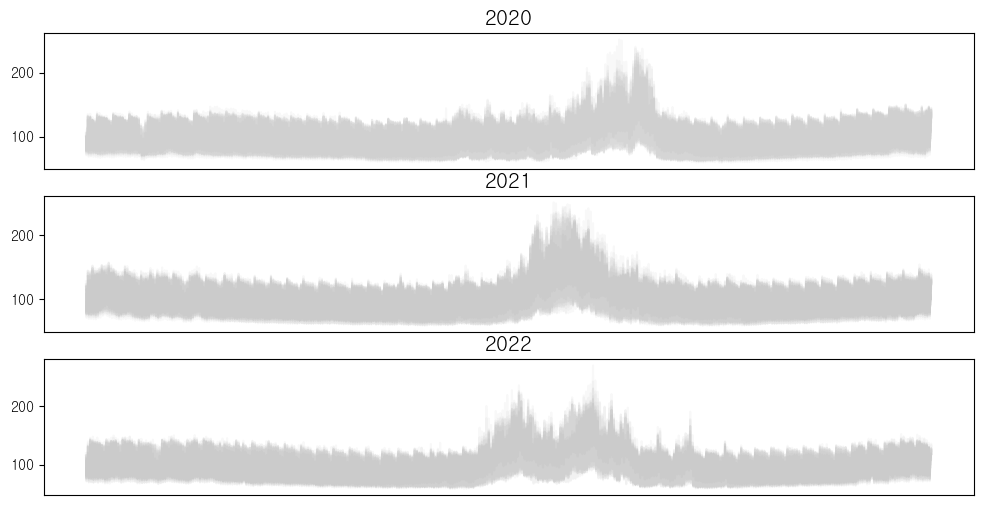

In [113]:
import random

random_num = random.choices(train.num, k=10)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 6))
for i in range(3):
    ax[i].set_title(2020 + i, fontsize=15)
    ax[i].xaxis.set_visible(False)
    # ax[i].yaxis.set_visible(False)

for n in random_num:
    temp = train[train.num == n] # 랜덤으로 추출한 격자의 데이터프레임 temp
    temp = temp[:-1] # 마지막행 삭제 (마지막행은 새롭게 시작하는 해의 00시에 해당하는 데이터이므로 처리를 위해 삭제)

    for i in range(3):
        temp2 = temp[temp.tm.apply(lambda x : x.year) == 2020+i]

        # 일별 elec 평균을 산출하여 새로운 열로 붙이기
        elec_mean_byday = temp2.groupby(["month", "day"]).agg({'elec' : 'mean'})
        pd.merge(temp2, elec_mean_byday, on=["month", "day"], how="inner")

        ax[i].plot(temp2.tm, temp2.elec, color="gray", alpha=0.05)

train test split : test가 모두 23년 데이터에 대한 값이므로, 22년의 데이터를 모두 validation set으로 사용

In [7]:
# train[(train['year'] >= 2022)]
train_df = train[train['tm'] <= '2022-01-01 00:00:00']
valid_df = train[train['tm'] > '2022-01-01 00:00:00']

train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

train_df

,num,tm,hh24,stn,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi,weekday,week_name,elec,year,month,day
0,4821,2021-01-01 01:00:00,1,884,2.2,62.7,1.8,0.0,-1.0,4,0,99.56,2021,1,1
1,4821,2021-01-01 02:00:00,2,884,2.3,63.1,2.1,0.0,-0.6,4,0,91.78,2021,1,1
2,4821,2021-01-01 03:00:00,3,884,2.2,62.4,2.5,0.0,-1.3,4,0,79.17,2021,1,1
3,4821,2021-01-01 04:00:00,4,884,1.7,63.5,1.7,0.0,-0.2,4,0,73.34,2021,1,1
4,4821,2021-01-01 05:00:00,5,884,1.7,63.0,1.6,0.0,-0.8,4,0,69.73,2021,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5254432,20947,2021-12-31 20:00:00,20,671,-4.3,27.4,1.7,0.0,-7.0,4,0,139.90,2021,12,31
5254433,20947,2021-12-31 21:00:00,21,671,-4.7,29.2,1.7,0.0,-8.6,4,0,140.55,2021,12,31
5254434,20947,2021-12-31 22:00:00,22,671,-5.3,32.6,1.0,0.0,-8.8,4,0,139.96,2021,12,31
5254435,20947,2021-12-31 23:00:00,23,671,-6.5,36.0,1.1,0.0,-9.4,4,0,134.00,2021,12,31


In [9]:
valid_df

,num,tm,hh24,stn,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi,weekday,week_name,elec,year,month,day
0,5565,2022-01-01 01:00:00,1,184,3.2,66.7,1.8,0.0,0.6,5,1,92.23,2022,1,1
1,5565,2022-01-01 02:00:00,2,184,3.0,60.6,2.5,0.0,-0.1,5,1,83.16,2022,1,1
2,5565,2022-01-01 03:00:00,3,184,2.7,63.6,2.7,0.0,-0.9,5,1,76.44,2022,1,1
3,5565,2022-01-01 04:00:00,4,184,2.1,64.2,2.2,0.0,-1.0,5,1,70.19,2022,1,1
4,5565,2022-01-01 05:00:00,5,184,1.9,68.6,1.6,0.0,-1.0,5,1,68.53,2022,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2338913,20947,2022-12-31 20:00:00,20,671,2.7,46.3,3.1,0.0,-0.4,5,1,130.74,2022,12,31
2338914,20947,2022-12-31 21:00:00,21,671,2.6,46.8,3.1,0.0,-0.5,5,1,131.18,2022,12,31
2338915,20947,2022-12-31 22:00:00,22,671,2.4,47.4,2.1,0.0,0.2,5,1,129.33,2022,12,31
2338916,20947,2022-12-31 23:00:00,23,671,2.5,47.0,2.1,0.0,0.3,5,1,122.57,2022,12,31


In [120]:
len(train_df)/len(train)

0.6919783152506369

파생변수 생성

In [10]:
# 파생변수 생성
# 1. 여름 여부
train_df['summer'] = 0
train_df.loc[(train_df['month'] >= 6) & (train_df['month'] <= 8), 'summer'] = 1
train_df

,num,tm,hh24,stn,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi,weekday,week_name,elec,year,month,day,summer
0,4821,2021-01-01 01:00:00,1,884,2.2,62.7,1.8,0.0,-1.0,4,0,99.56,2021,1,1,0
1,4821,2021-01-01 02:00:00,2,884,2.3,63.1,2.1,0.0,-0.6,4,0,91.78,2021,1,1,0
2,4821,2021-01-01 03:00:00,3,884,2.2,62.4,2.5,0.0,-1.3,4,0,79.17,2021,1,1,0
3,4821,2021-01-01 04:00:00,4,884,1.7,63.5,1.7,0.0,-0.2,4,0,73.34,2021,1,1,0
4,4821,2021-01-01 05:00:00,5,884,1.7,63.0,1.6,0.0,-0.8,4,0,69.73,2021,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5254432,20947,2021-12-31 20:00:00,20,671,-4.3,27.4,1.7,0.0,-7.0,4,0,139.90,2021,12,31,0
5254433,20947,2021-12-31 21:00:00,21,671,-4.7,29.2,1.7,0.0,-8.6,4,0,140.55,2021,12,31,0
5254434,20947,2021-12-31 22:00:00,22,671,-5.3,32.6,1.0,0.0,-8.8,4,0,139.96,2021,12,31,0
5254435,20947,2021-12-31 23:00:00,23,671,-6.5,36.0,1.1,0.0,-9.4,4,0,134.00,2021,12,31,0


In [12]:
# valid set에도 똑같이 파생변수 생성
valid_df['summer'] = 0
valid_df.loc[(valid_df['month'] >= 6) & (valid_df['month'] <= 8), 'summer'] = 1


In [13]:
train_df

,num,tm,hh24,stn,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi,weekday,week_name,elec,year,month,day,summer
0,4821,2021-01-01 01:00:00,1,884,2.2,62.7,1.8,0.0,-1.0,4,0,99.56,2021,1,1,0
1,4821,2021-01-01 02:00:00,2,884,2.3,63.1,2.1,0.0,-0.6,4,0,91.78,2021,1,1,0
2,4821,2021-01-01 03:00:00,3,884,2.2,62.4,2.5,0.0,-1.3,4,0,79.17,2021,1,1,0
3,4821,2021-01-01 04:00:00,4,884,1.7,63.5,1.7,0.0,-0.2,4,0,73.34,2021,1,1,0
4,4821,2021-01-01 05:00:00,5,884,1.7,63.0,1.6,0.0,-0.8,4,0,69.73,2021,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5254432,20947,2021-12-31 20:00:00,20,671,-4.3,27.4,1.7,0.0,-7.0,4,0,139.90,2021,12,31,0
5254433,20947,2021-12-31 21:00:00,21,671,-4.7,29.2,1.7,0.0,-8.6,4,0,140.55,2021,12,31,0
5254434,20947,2021-12-31 22:00:00,22,671,-5.3,32.6,1.0,0.0,-8.8,4,0,139.96,2021,12,31,0
5254435,20947,2021-12-31 23:00:00,23,671,-6.5,36.0,1.1,0.0,-9.4,4,0,134.00,2021,12,31,0


In [14]:
valid_df

,num,tm,hh24,stn,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi,weekday,week_name,elec,year,month,day,summer
0,5565,2022-01-01 01:00:00,1,184,3.2,66.7,1.8,0.0,0.6,5,1,92.23,2022,1,1,0
1,5565,2022-01-01 02:00:00,2,184,3.0,60.6,2.5,0.0,-0.1,5,1,83.16,2022,1,1,0
2,5565,2022-01-01 03:00:00,3,184,2.7,63.6,2.7,0.0,-0.9,5,1,76.44,2022,1,1,0
3,5565,2022-01-01 04:00:00,4,184,2.1,64.2,2.2,0.0,-1.0,5,1,70.19,2022,1,1,0
4,5565,2022-01-01 05:00:00,5,184,1.9,68.6,1.6,0.0,-1.0,5,1,68.53,2022,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2338913,20947,2022-12-31 20:00:00,20,671,2.7,46.3,3.1,0.0,-0.4,5,1,130.74,2022,12,31,0
2338914,20947,2022-12-31 21:00:00,21,671,2.6,46.8,3.1,0.0,-0.5,5,1,131.18,2022,12,31,0
2338915,20947,2022-12-31 22:00:00,22,671,2.4,47.4,2.1,0.0,0.2,5,1,129.33,2022,12,31,0
2338916,20947,2022-12-31 23:00:00,23,671,2.5,47.0,2.1,0.0,0.3,5,1,122.57,2022,12,31,0


In [15]:
# 예시로 test할 지역 산출
def get_random_unique_stn_values(df, column_name, num_values=5):
    # 고유값 추출
    unique_values = df[column_name].unique()
    
    # 고유값이 충분하지 않은 경우 예외 처리
    if len(unique_values) < num_values:
        raise ValueError(f"열 {column_name}에 고유값이 {num_values}개 이상 존재하지 않습니다.")
    
    # 랜덤으로 고유값 선택
    random_values = np.random.choice(unique_values, size=num_values, replace=False)
    
    return random_values

# 함수 호출 예시
random_stn_values = get_random_unique_stn_values(valid_df, 'num', 1)
print(random_stn_values)

[14968]


In [16]:
# 예시 지역 선정
loca = valid_df[valid_df['num'].isin(random_stn_values)].index
# 'tm' 변수를 x축으로 사용
dates = valid_df.loc[loca, 'tm']

장소 변수 추가

In [17]:
aws = pd.read_csv('aws_data_fin.csv', encoding='cp949')
location = pd.read_csv('META_관측지점정보_20240621010501.csv', encoding='cp949')

print(aws.head())
print(location.head())

   AWS     지점    고도 강수 강수15 강수60 강수3H 강수6H 강수12H 일강수    기온    풍향1 Unnamed: 12  \
0   90     속초   18m  ○    0    0    0    0     0   0  27.4    126          SE   
1   92  양양(공)   75m  -    .    .    .    .     .   0  26.1    120         ESE   
2   93    북춘천   96m  ○    0    0    0    0     0   0    33  261.4           W   
3   95     철원  155m  ○    0    0    0    0     0   0  32.7  295.9         WNW   
4   96     독도   99m  ○    0    0    0    0     0   0  24.1  267.2           W   

  풍속1(m/s)   풍향10 Unnamed: 15 풍속10(m/s)  습도    해면기압                   위치  
0      2.9  127.1          SE       3.1  66  1007.6  강원특별자치도 고성군 토성면 봉포리  
1      3.7    110         ESE       4.8  70  1007.4  강원특별자치도 양양군 손양면 동호리  
2      1.7  254.5         WSW       1.2  39  1007.7  강원특별자치도 춘천시 신북읍 산천리  
3      1.5  262.5           W       1.5  38  1007.7  강원특별자치도 철원군 갈말읍 군탄리  
4      0.6  261.6           W       1.1  83    1009     경상북도 울릉군 울릉읍 독도리  
   지점         시작일  종료일     지점명 지점주소 관리관서       위도        경도  노장

In [18]:
# location.columns
pd.merge(aws, location[['지점', '경도', '위도']], left_on='AWS', right_on='지점', how='left')

,AWS,지점_x,고도,강수,강수15,강수60,강수3H,강수6H,강수12H,일강수,...,풍속1(m/s),풍향10,Unnamed: 15,풍속10(m/s),습도,해면기압,위치,지점_y,경도,위도
0,90,속초,18m,○,0,0,0,0,0,0,...,2.9,127.1,SE,3.1,66,1007.6,강원특별자치도 고성군 토성면 봉포리,90.0,128.5647,38.2509
1,90,속초,18m,○,0,0,0,0,0,0,...,2.9,127.1,SE,3.1,66,1007.6,강원특별자치도 고성군 토성면 봉포리,90.0,128.5647,38.2509
2,92,양양(공),75m,-,.,.,.,.,.,0,...,3.7,110,ESE,4.8,70,1007.4,강원특별자치도 양양군 손양면 동호리,92.0,128.6667,38.0667
3,93,북춘천,96m,○,0,0,0,0,0,0,...,1.7,254.5,WSW,1.2,39,1007.7,강원특별자치도 춘천시 신북읍 산천리,93.0,127.7544,37.9474
4,93,북춘천,96m,○,0,0,0,0,0,0,...,1.7,254.5,WSW,1.2,39,1007.7,강원특별자치도 춘천시 신북읍 산천리,93.0,127.7547,37.9475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577,992,하빈,36m,○,0,0,0,0,0,0,...,1.6,218.3,SW,2.1,36,1007.7,대구광역시 달성군 하빈면 현내리,992.0,128.4464,35.9062
2578,993,제주금악,279m,○,0,0,0,0,0,0,...,3.4,133,SE,3.6,61,1009.1,제주특별자치도 제주시 한림읍 금악리,993.0,126.3099,33.3423
2579,994,심포,3m,○,0,0,0,0,0,0,...,2.4,41.8,NE,1.6,42,1008.3,전북특별자치도 김제시 진봉면,994.0,126.6421,35.8545
2580,995,오천,80m,○,0,0,0,0,0,0,...,2.6,153,SSE,2.3,33,1007.2,경상북도 포항시남구 오천읍 항사리,995.0,129.3822,35.9286


In [19]:
# 위도 및 경도 변수 생성
# location 데이터프레임에서 중복되는 지점 중 가장 마지막 값을 유지
location = location.drop_duplicates(subset=['지점'], keep='last')

# 데이터프레임 병합
merged_aws = pd.merge(aws, location[['지점', '경도', '위도']], left_on='AWS', right_on='지점', how='left')

# 필요 없는 열 제거
merged_aws.drop(columns=['지점_y'], inplace=True)

# 각 AWS의 위도와 경도를 동일하게 설정
# merged_df['위도'] = merged_df.groupby('AWS')['위도'].transform('last')
# merged_df['경도'] = merged_df.groupby('AWS')['경도'].transform('last')

# 결과 출력
print(merged_aws)

     AWS   지점_x    고도 강수 강수15 강수60 강수3H 강수6H 강수12H 일강수  ... Unnamed: 12  \
0     90     속초   18m  ○    0    0    0    0     0   0  ...          SE   
1     92  양양(공)   75m  -    .    .    .    .     .   0  ...         ESE   
2     93    북춘천   96m  ○    0    0    0    0     0   0  ...           W   
3     95     철원  155m  ○    0    0    0    0     0   0  ...         WNW   
4     96     독도   99m  ○    0    0    0    0     0   0  ...           W   
..   ...    ...   ... ..  ...  ...  ...  ...   ...  ..  ...         ...   
721  992     하빈   36m  ○    0    0    0    0     0   0  ...         WSW   
722  993   제주금악  279m  ○    0    0    0    0     0   0  ...          SE   
723  994     심포    3m  ○    0    0    0    0     0   0  ...         NNE   
724  995     오천   80m  ○    0    0    0    0     0   0  ...           S   
725  996     화동  360m  ○    0    0    0    0     0   0  ...          SE   

    풍속1(m/s)   풍향10 Unnamed: 15 풍속10(m/s)  습도    해면기압                   위치  \
0        2.9  127.1  

In [20]:
# loca 열의 문자열 처리
def extract_location(loca):
    if loca.startswith('(산지)'):
        return loca[4:6]  # '(산지)' 이후의 두 글자
    else:
        return loca[:2]   # 맨 앞의 두 글자

# loca 열에서 location 열 생성
merged_aws['location'] = merged_aws['위치'].apply(extract_location)

# loca 열에서 mountain 열 생성
merged_aws['mountain'] = merged_aws['위치'].apply(lambda x: 1 if x.startswith('(산지)') else 0)

print(merged_aws)

     AWS   지점_x    고도 강수 강수15 강수60 강수3H 강수6H 강수12H 일강수  ...   풍향10  \
0     90     속초   18m  ○    0    0    0    0     0   0  ...  127.1   
1     92  양양(공)   75m  -    .    .    .    .     .   0  ...    110   
2     93    북춘천   96m  ○    0    0    0    0     0   0  ...  254.5   
3     95     철원  155m  ○    0    0    0    0     0   0  ...  262.5   
4     96     독도   99m  ○    0    0    0    0     0   0  ...  261.6   
..   ...    ...   ... ..  ...  ...  ...  ...   ...  ..  ...    ...   
721  992     하빈   36m  ○    0    0    0    0     0   0  ...  218.3   
722  993   제주금악  279m  ○    0    0    0    0     0   0  ...    133   
723  994     심포    3m  ○    0    0    0    0     0   0  ...   41.8   
724  995     오천   80m  ○    0    0    0    0     0   0  ...    153   
725  996     화동  360m  ○    0    0    0    0     0   0  ...  125.3   

    Unnamed: 15 풍속10(m/s)  습도    해면기압                   위치        경도       위도  \
0            SE       3.1  66  1007.6  강원특별자치도 고성군 토성면 봉포리  128.5647  38.2509 

In [21]:
merged_aws

,AWS,지점_x,고도,강수,강수15,강수60,강수3H,강수6H,강수12H,일강수,...,풍향10,Unnamed: 15,풍속10(m/s),습도,해면기압,위치,경도,위도,location,mountain
0,90,속초,18m,○,0,0,0,0,0,0,...,127.1,SE,3.1,66,1007.6,강원특별자치도 고성군 토성면 봉포리,128.5647,38.2509,강원,0
1,92,양양(공),75m,-,.,.,.,.,.,0,...,110,ESE,4.8,70,1007.4,강원특별자치도 양양군 손양면 동호리,128.6667,38.0667,강원,0
2,93,북춘천,96m,○,0,0,0,0,0,0,...,254.5,WSW,1.2,39,1007.7,강원특별자치도 춘천시 신북읍 산천리,127.7547,37.9475,강원,0
3,95,철원,155m,○,0,0,0,0,0,0,...,262.5,W,1.5,38,1007.7,강원특별자치도 철원군 갈말읍 군탄리,127.3042,38.1479,강원,0
4,96,독도,99m,○,0,0,0,0,0,0,...,261.6,W,1.1,83,1009,경상북도 울릉군 울릉읍 독도리,131.8698,37.2395,경상,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721,992,하빈,36m,○,0,0,0,0,0,0,...,218.3,SW,2.1,36,1007.7,대구광역시 달성군 하빈면 현내리,128.4464,35.9062,대구,0
722,993,제주금악,279m,○,0,0,0,0,0,0,...,133,SE,3.6,61,1009.1,제주특별자치도 제주시 한림읍 금악리,126.3099,33.3423,제주,0
723,994,심포,3m,○,0,0,0,0,0,0,...,41.8,NE,1.6,42,1008.3,전북특별자치도 김제시 진봉면,126.6421,35.8545,전북,0
724,995,오천,80m,○,0,0,0,0,0,0,...,153,SSE,2.3,33,1007.2,경상북도 포항시남구 오천읍 항사리,129.3822,35.9286,경상,0


In [22]:
# '고도' 변수에서 'm'을 제거하고 실수형으로 변환
merged_aws['고도'] = merged_aws['고도'].str.replace('m', '').astype(float)

# 결과 출력
merged_aws

,AWS,지점_x,고도,강수,강수15,강수60,강수3H,강수6H,강수12H,일강수,...,풍향10,Unnamed: 15,풍속10(m/s),습도,해면기압,위치,경도,위도,location,mountain
0,90,속초,18.0,○,0,0,0,0,0,0,...,127.1,SE,3.1,66,1007.6,강원특별자치도 고성군 토성면 봉포리,128.5647,38.2509,강원,0
1,92,양양(공),75.0,-,.,.,.,.,.,0,...,110,ESE,4.8,70,1007.4,강원특별자치도 양양군 손양면 동호리,128.6667,38.0667,강원,0
2,93,북춘천,96.0,○,0,0,0,0,0,0,...,254.5,WSW,1.2,39,1007.7,강원특별자치도 춘천시 신북읍 산천리,127.7547,37.9475,강원,0
3,95,철원,155.0,○,0,0,0,0,0,0,...,262.5,W,1.5,38,1007.7,강원특별자치도 철원군 갈말읍 군탄리,127.3042,38.1479,강원,0
4,96,독도,99.0,○,0,0,0,0,0,0,...,261.6,W,1.1,83,1009,경상북도 울릉군 울릉읍 독도리,131.8698,37.2395,경상,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721,992,하빈,36.0,○,0,0,0,0,0,0,...,218.3,SW,2.1,36,1007.7,대구광역시 달성군 하빈면 현내리,128.4464,35.9062,대구,0
722,993,제주금악,279.0,○,0,0,0,0,0,0,...,133,SE,3.6,61,1009.1,제주특별자치도 제주시 한림읍 금악리,126.3099,33.3423,제주,0
723,994,심포,3.0,○,0,0,0,0,0,0,...,41.8,NE,1.6,42,1008.3,전북특별자치도 김제시 진봉면,126.6421,35.8545,전북,0
724,995,오천,80.0,○,0,0,0,0,0,0,...,153,SSE,2.3,33,1007.2,경상북도 포항시남구 오천읍 항사리,129.3822,35.9286,경상,0


In [23]:
# 위도 및 경도 변수 생성
# location 데이터프레임에서 중복되는 지점 중 가장 마지막 값을 유지
train_df = pd.merge(train_df, merged_aws[['AWS', '경도', '위도', '고도', 'location', 'mountain']], left_on='stn', right_on='AWS', how='left')

# 필요 없는 열 제거
train_df.drop(columns=['AWS'], inplace=True)

# 각 AWS의 위도와 경도를 동일하게 설정
# merged_df['위도'] = merged_df.groupby('AWS')['위도'].transform('last')
# merged_df['경도'] = merged_df.groupby('AWS')['경도'].transform('last')

# 결과 출력
train_df

,num,tm,hh24,stn,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi,weekday,...,elec,year,month,day,summer,경도,위도,고도,location,mountain
0,4821,2021-01-01 01:00:00,1,884,2.2,62.7,1.8,0.0,-1.0,4,...,99.56,2021,1,1,0,126.5176,33.2593,173.0,제주,0
1,4821,2021-01-01 02:00:00,2,884,2.3,63.1,2.1,0.0,-0.6,4,...,91.78,2021,1,1,0,126.5176,33.2593,173.0,제주,0
2,4821,2021-01-01 03:00:00,3,884,2.2,62.4,2.5,0.0,-1.3,4,...,79.17,2021,1,1,0,126.5176,33.2593,173.0,제주,0
3,4821,2021-01-01 04:00:00,4,884,1.7,63.5,1.7,0.0,-0.2,4,...,73.34,2021,1,1,0,126.5176,33.2593,173.0,제주,0
4,4821,2021-01-01 05:00:00,5,884,1.7,63.0,1.6,0.0,-0.8,4,...,69.73,2021,1,1,0,126.5176,33.2593,173.0,제주,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5254432,20947,2021-12-31 20:00:00,20,671,-4.3,27.4,1.7,0.0,-7.0,4,...,139.90,2021,12,31,0,128.5941,38.1988,4.0,강원,0
5254433,20947,2021-12-31 21:00:00,21,671,-4.7,29.2,1.7,0.0,-8.6,4,...,140.55,2021,12,31,0,128.5941,38.1988,4.0,강원,0
5254434,20947,2021-12-31 22:00:00,22,671,-5.3,32.6,1.0,0.0,-8.8,4,...,139.96,2021,12,31,0,128.5941,38.1988,4.0,강원,0
5254435,20947,2021-12-31 23:00:00,23,671,-6.5,36.0,1.1,0.0,-9.4,4,...,134.00,2021,12,31,0,128.5941,38.1988,4.0,강원,0


In [24]:
seoul_OX = ['서울', '경기', '인천']
train_df['수도권여부'] = 0
train_df.loc[train_df['location'].isin(seoul_OX), '수도권여부'] = 1
# train_df.drop(columns=['location'], inplace=True)
train_df

,num,tm,hh24,stn,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi,weekday,...,year,month,day,summer,경도,위도,고도,location,mountain,수도권여부
0,4821,2021-01-01 01:00:00,1,884,2.2,62.7,1.8,0.0,-1.0,4,...,2021,1,1,0,126.5176,33.2593,173.0,제주,0,0
1,4821,2021-01-01 02:00:00,2,884,2.3,63.1,2.1,0.0,-0.6,4,...,2021,1,1,0,126.5176,33.2593,173.0,제주,0,0
2,4821,2021-01-01 03:00:00,3,884,2.2,62.4,2.5,0.0,-1.3,4,...,2021,1,1,0,126.5176,33.2593,173.0,제주,0,0
3,4821,2021-01-01 04:00:00,4,884,1.7,63.5,1.7,0.0,-0.2,4,...,2021,1,1,0,126.5176,33.2593,173.0,제주,0,0
4,4821,2021-01-01 05:00:00,5,884,1.7,63.0,1.6,0.0,-0.8,4,...,2021,1,1,0,126.5176,33.2593,173.0,제주,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5254432,20947,2021-12-31 20:00:00,20,671,-4.3,27.4,1.7,0.0,-7.0,4,...,2021,12,31,0,128.5941,38.1988,4.0,강원,0,0
5254433,20947,2021-12-31 21:00:00,21,671,-4.7,29.2,1.7,0.0,-8.6,4,...,2021,12,31,0,128.5941,38.1988,4.0,강원,0,0
5254434,20947,2021-12-31 22:00:00,22,671,-5.3,32.6,1.0,0.0,-8.8,4,...,2021,12,31,0,128.5941,38.1988,4.0,강원,0,0
5254435,20947,2021-12-31 23:00:00,23,671,-6.5,36.0,1.1,0.0,-9.4,4,...,2021,12,31,0,128.5941,38.1988,4.0,강원,0,0


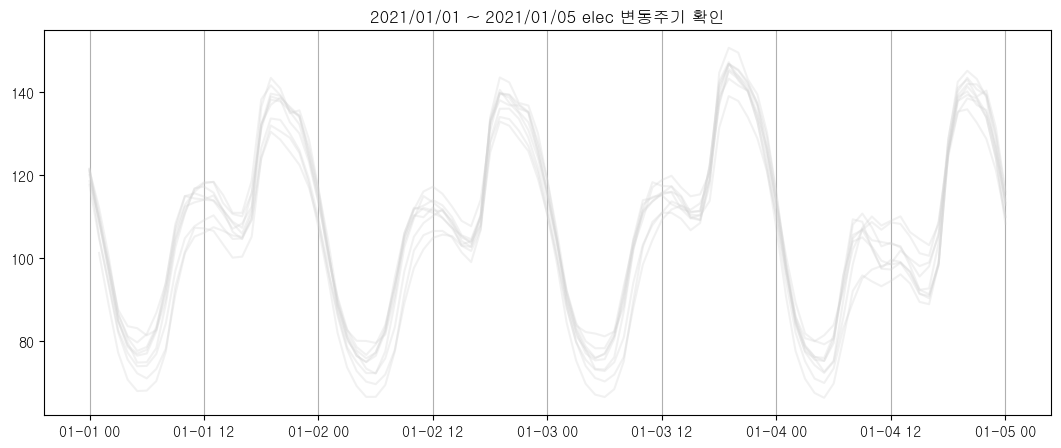

In [115]:
from datetime import datetime

random_num = random.choices(train_df.num, k=10)
plt.figure(figsize=(13, 5))
plt.grid(True, axis="x")
plt.title("2021/01/01 ~ 2021/01/05 elec 변동주기 확인")

for n in random_num:
    temp = train_df[(datetime(2021, 1, 1) <= train_df.tm) & (train_df.tm <= datetime(2021, 1, 5)) & (train_df.num == n)]
    plt.plot(temp.tm, temp.elec, color="lightgray", alpha=.3)

In [25]:
# 시간 변수 생성 : 시간
train_df['sin_time'] = np.sin(2 * np.pi * train_df['hh24'] / 24)
train_df['cos_time'] = np.cos(2 * np.pi * train_df['hh24'] / 24)

In [26]:
# 시간 변수 생성 : month
train_df['sin_month'] = np.sin(2 * np.pi * train_df['month'] / 12)
train_df['cos_month'] = np.cos(2 * np.pi * train_df['month'] / 12)

In [27]:
# 오후 여부 변수 추가
train_df['afternoon'] = 0
train_df.loc[(train_df['hh24'] >= 12)&(train_df['hh24'] <= 15), 'afternoon'] = 1

In [28]:
# 여름 내의 주기성은 따로 반영
import datetime
import math

def summer_cos(date):
    start_date = date.min()
    # datetime.strptime("2022-06-01 00:00:00", "%Y-%m-%d %H:%M:%S")
    end_date = date.max()

    period = (end_date - start_date).total_seconds()

    return np.cos(2 * math.pi * (date - start_date).apply(lambda x: x.total_seconds()) / period)

def summer_sin(date):
    start_date = date.min()
    end_date = date.max()

    period = (end_date - start_date).total_seconds()

    return np.sin(2 * math.pi * (date - start_date).apply(lambda x: x.total_seconds()) / period)


In [29]:
train_df['summer_cos'] = 0
train_df.loc[(train_df['summer'] == 1) & (train_df['year'] == 2020), 'summer_cos'] = summer_cos(train_df.loc[(train_df['summer'] == 1) & (train_df['year'] == 2020), 'tm'])
train_df.loc[(train_df['summer'] == 1) & (train_df['year'] == 2021), 'summer_cos'] = summer_cos(train_df.loc[(train_df['summer'] == 1) & (train_df['year'] == 2021), 'tm'])

In [30]:
train_df['summer_sin'] = 0
train_df.loc[(train_df['summer'] == 1) & (train_df['year'] == 2020), 'summer_sin'] = summer_sin(train_df.loc[(train_df['summer'] == 1) & (train_df['year'] == 2020), 'tm'])
train_df.loc[(train_df['summer'] == 1) & (train_df['year'] == 2021), 'summer_sin'] = summer_sin(train_df.loc[(train_df['summer'] == 1) & (train_df['year'] == 2021), 'tm'])

In [31]:
train_df

,num,tm,hh24,stn,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi,weekday,...,location,mountain,수도권여부,sin_time,cos_time,sin_month,cos_month,afternoon,summer_cos,summer_sin
0,4821,2021-01-01 01:00:00,1,884,2.2,62.7,1.8,0.0,-1.0,4,...,제주,0,0,2.588190e-01,0.965926,5.000000e-01,0.866025,0,0.0,0.0
1,4821,2021-01-01 02:00:00,2,884,2.3,63.1,2.1,0.0,-0.6,4,...,제주,0,0,5.000000e-01,0.866025,5.000000e-01,0.866025,0,0.0,0.0
2,4821,2021-01-01 03:00:00,3,884,2.2,62.4,2.5,0.0,-1.3,4,...,제주,0,0,7.071068e-01,0.707107,5.000000e-01,0.866025,0,0.0,0.0
3,4821,2021-01-01 04:00:00,4,884,1.7,63.5,1.7,0.0,-0.2,4,...,제주,0,0,8.660254e-01,0.500000,5.000000e-01,0.866025,0,0.0,0.0
4,4821,2021-01-01 05:00:00,5,884,1.7,63.0,1.6,0.0,-0.8,4,...,제주,0,0,9.659258e-01,0.258819,5.000000e-01,0.866025,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5254432,20947,2021-12-31 20:00:00,20,671,-4.3,27.4,1.7,0.0,-7.0,4,...,강원,0,0,-8.660254e-01,0.500000,-2.449294e-16,1.000000,0,0.0,0.0
5254433,20947,2021-12-31 21:00:00,21,671,-4.7,29.2,1.7,0.0,-8.6,4,...,강원,0,0,-7.071068e-01,0.707107,-2.449294e-16,1.000000,0,0.0,0.0
5254434,20947,2021-12-31 22:00:00,22,671,-5.3,32.6,1.0,0.0,-8.8,4,...,강원,0,0,-5.000000e-01,0.866025,-2.449294e-16,1.000000,0,0.0,0.0
5254435,20947,2021-12-31 23:00:00,23,671,-6.5,36.0,1.1,0.0,-9.4,4,...,강원,0,0,-2.588190e-01,0.965926,-2.449294e-16,1.000000,0,0.0,0.0


In [32]:
# valid에도 똑같이 전처리!
# 위도 및 경도 변수 생성
# location 데이터프레임에서 중복되는 지점 중 가장 마지막 값을 유지
valid_df = pd.merge(valid_df, merged_aws[['AWS', '경도', '위도', '고도', 'location', 'mountain']], left_on='stn', right_on='AWS', how='left')

# 필요 없는 열 제거
valid_df.drop(columns=['AWS'], inplace=True)

# 각 AWS의 위도와 경도를 동일하게 설정
# merged_df['위도'] = merged_df.groupby('AWS')['위도'].transform('last')
# merged_df['경도'] = merged_df.groupby('AWS')['경도'].transform('last')

# 결과 출력
valid_df


,num,tm,hh24,stn,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi,weekday,...,elec,year,month,day,summer,경도,위도,고도,location,mountain
0,5565,2022-01-01 01:00:00,1,184,3.2,66.7,1.8,0.0,0.6,5,...,92.23,2022,1,1,0,126.5297,33.5141,21.0,제주,0
1,5565,2022-01-01 02:00:00,2,184,3.0,60.6,2.5,0.0,-0.1,5,...,83.16,2022,1,1,0,126.5297,33.5141,21.0,제주,0
2,5565,2022-01-01 03:00:00,3,184,2.7,63.6,2.7,0.0,-0.9,5,...,76.44,2022,1,1,0,126.5297,33.5141,21.0,제주,0
3,5565,2022-01-01 04:00:00,4,184,2.1,64.2,2.2,0.0,-1.0,5,...,70.19,2022,1,1,0,126.5297,33.5141,21.0,제주,0
4,5565,2022-01-01 05:00:00,5,184,1.9,68.6,1.6,0.0,-1.0,5,...,68.53,2022,1,1,0,126.5297,33.5141,21.0,제주,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2338913,20947,2022-12-31 20:00:00,20,671,2.7,46.3,3.1,0.0,-0.4,5,...,130.74,2022,12,31,0,128.5941,38.1988,4.0,강원,0
2338914,20947,2022-12-31 21:00:00,21,671,2.6,46.8,3.1,0.0,-0.5,5,...,131.18,2022,12,31,0,128.5941,38.1988,4.0,강원,0
2338915,20947,2022-12-31 22:00:00,22,671,2.4,47.4,2.1,0.0,0.2,5,...,129.33,2022,12,31,0,128.5941,38.1988,4.0,강원,0
2338916,20947,2022-12-31 23:00:00,23,671,2.5,47.0,2.1,0.0,0.3,5,...,122.57,2022,12,31,0,128.5941,38.1988,4.0,강원,0


In [33]:
seoul_OX = ['서울', '경기', '인천']
valid_df['수도권여부'] = 0
valid_df.loc[valid_df['location'].isin(seoul_OX), '수도권여부'] = 1
# train_df.drop(columns=['location'], inplace=True)
valid_df

,num,tm,hh24,stn,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi,weekday,...,year,month,day,summer,경도,위도,고도,location,mountain,수도권여부
0,5565,2022-01-01 01:00:00,1,184,3.2,66.7,1.8,0.0,0.6,5,...,2022,1,1,0,126.5297,33.5141,21.0,제주,0,0
1,5565,2022-01-01 02:00:00,2,184,3.0,60.6,2.5,0.0,-0.1,5,...,2022,1,1,0,126.5297,33.5141,21.0,제주,0,0
2,5565,2022-01-01 03:00:00,3,184,2.7,63.6,2.7,0.0,-0.9,5,...,2022,1,1,0,126.5297,33.5141,21.0,제주,0,0
3,5565,2022-01-01 04:00:00,4,184,2.1,64.2,2.2,0.0,-1.0,5,...,2022,1,1,0,126.5297,33.5141,21.0,제주,0,0
4,5565,2022-01-01 05:00:00,5,184,1.9,68.6,1.6,0.0,-1.0,5,...,2022,1,1,0,126.5297,33.5141,21.0,제주,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2338913,20947,2022-12-31 20:00:00,20,671,2.7,46.3,3.1,0.0,-0.4,5,...,2022,12,31,0,128.5941,38.1988,4.0,강원,0,0
2338914,20947,2022-12-31 21:00:00,21,671,2.6,46.8,3.1,0.0,-0.5,5,...,2022,12,31,0,128.5941,38.1988,4.0,강원,0,0
2338915,20947,2022-12-31 22:00:00,22,671,2.4,47.4,2.1,0.0,0.2,5,...,2022,12,31,0,128.5941,38.1988,4.0,강원,0,0
2338916,20947,2022-12-31 23:00:00,23,671,2.5,47.0,2.1,0.0,0.3,5,...,2022,12,31,0,128.5941,38.1988,4.0,강원,0,0


In [34]:
# 시간 변수 생성 : 시간
valid_df['sin_time'] = np.sin(2 * np.pi * valid_df['hh24'] / 24)
valid_df['cos_time'] = np.cos(2 * np.pi * valid_df['hh24'] / 24)

In [35]:
# 시간 변수 생성 : 월
valid_df['sin_month'] = np.sin(2 * np.pi * valid_df['month'] / 12)
valid_df['cos_month'] = np.cos(2 * np.pi * valid_df['month'] / 12)

In [36]:
# 오후 여부 변수 추가
valid_df['afternoon'] = 0
valid_df.loc[(valid_df['hh24'] >= 12)&(valid_df['hh24'] <= 15), 'afternoon'] = 1

In [37]:
valid_df['summer_cos'] = 0
valid_df.loc[(valid_df['summer'] == 1) & (valid_df['year'] == 2022), 'summer_cos'] = summer_cos(valid_df.loc[(valid_df['summer'] == 1) & (valid_df['year'] == 2022), 'tm'])

In [38]:
valid_df['summer_sin'] = 0
valid_df.loc[(valid_df['summer'] == 1) & (valid_df['year'] == 2022), 'summer_sin'] = summer_sin(valid_df.loc[(valid_df['summer'] == 1) & (valid_df['year'] == 2022), 'tm'])

In [39]:
valid_df

,num,tm,hh24,stn,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi,weekday,...,location,mountain,수도권여부,sin_time,cos_time,sin_month,cos_month,afternoon,summer_cos,summer_sin
0,5565,2022-01-01 01:00:00,1,184,3.2,66.7,1.8,0.0,0.6,5,...,제주,0,0,2.588190e-01,0.965926,5.000000e-01,0.866025,0,0.0,0.0
1,5565,2022-01-01 02:00:00,2,184,3.0,60.6,2.5,0.0,-0.1,5,...,제주,0,0,5.000000e-01,0.866025,5.000000e-01,0.866025,0,0.0,0.0
2,5565,2022-01-01 03:00:00,3,184,2.7,63.6,2.7,0.0,-0.9,5,...,제주,0,0,7.071068e-01,0.707107,5.000000e-01,0.866025,0,0.0,0.0
3,5565,2022-01-01 04:00:00,4,184,2.1,64.2,2.2,0.0,-1.0,5,...,제주,0,0,8.660254e-01,0.500000,5.000000e-01,0.866025,0,0.0,0.0
4,5565,2022-01-01 05:00:00,5,184,1.9,68.6,1.6,0.0,-1.0,5,...,제주,0,0,9.659258e-01,0.258819,5.000000e-01,0.866025,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2338913,20947,2022-12-31 20:00:00,20,671,2.7,46.3,3.1,0.0,-0.4,5,...,강원,0,0,-8.660254e-01,0.500000,-2.449294e-16,1.000000,0,0.0,0.0
2338914,20947,2022-12-31 21:00:00,21,671,2.6,46.8,3.1,0.0,-0.5,5,...,강원,0,0,-7.071068e-01,0.707107,-2.449294e-16,1.000000,0,0.0,0.0
2338915,20947,2022-12-31 22:00:00,22,671,2.4,47.4,2.1,0.0,0.2,5,...,강원,0,0,-5.000000e-01,0.866025,-2.449294e-16,1.000000,0,0.0,0.0
2338916,20947,2022-12-31 23:00:00,23,671,2.5,47.0,2.1,0.0,0.3,5,...,강원,0,0,-2.588190e-01,0.965926,-2.449294e-16,1.000000,0,0.0,0.0


푸리에 변환을 통해 노이즈 제거

In [40]:
def denoise_fft(data, ifftn):
    # Fast Fourier Transformation
    fft_signal = np.fft.fft(data)
    
    # Reconstruct Original Signal
    fft_signal[ifftn:len(fft_signal)//2]=0
    fft_signal[len(fft_signal)//2:-ifftn]=0
    reconstructed_signal = np.fft.ifft(fft_signal)
    
    return reconstructed_signal.real

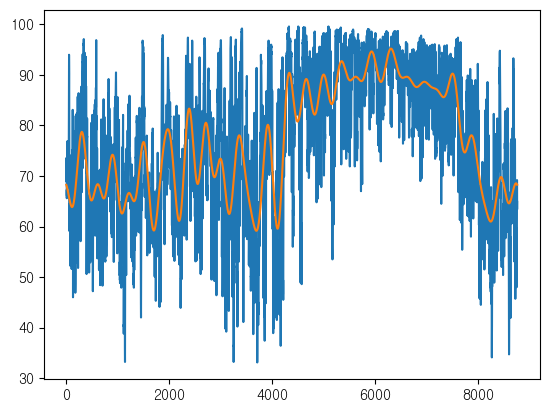

In [41]:
value_recon = denoise_fft(data=train_df.loc[loca, 'nph_hm'], ifftn=30)

plt.plot(train_df.loc[loca, 'nph_hm'].values)
plt.plot(value_recon)

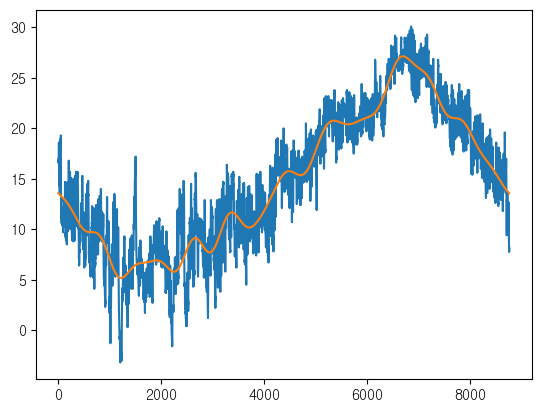

In [42]:
value_recon = denoise_fft(data=train_df.loc[loca, 'nph_ta'], ifftn=15)

plt.plot(train_df.loc[loca, 'nph_ta'].values)
plt.plot(value_recon)

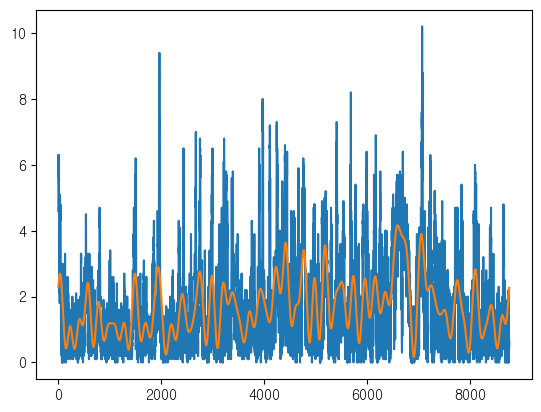

In [43]:
value_recon = denoise_fft(data=train_df.loc[loca, 'nph_ws_10m'], ifftn=50)

plt.plot(train_df.loc[loca, 'nph_ws_10m'].values)
plt.plot(value_recon)

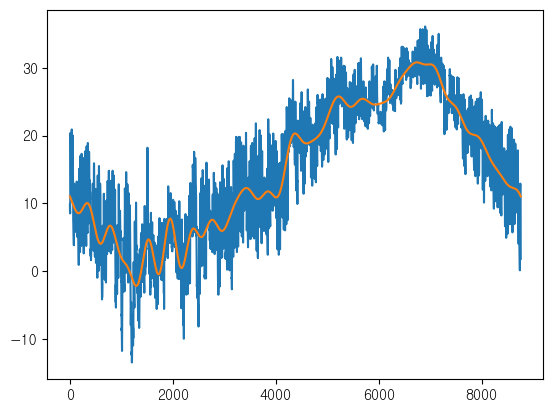

In [44]:
value_recon = denoise_fft(data=train_df.loc[loca, 'nph_ta_chi'], ifftn=25)

plt.plot(train_df.loc[loca, 'nph_ta_chi'].values)
plt.plot(value_recon)

In [45]:
train_df['denoise_hm'] = 0
for num in train_df['num'].unique():
    train_df.loc[train_df['num'] == num, 'denoise_hm'] = denoise_fft(data = train_df.loc[train_df['num'] == num, 'nph_hm'], ifftn=30)

valid_df['denoise_hm'] = 0
for num in valid_df['num'].unique():
    valid_df.loc[valid_df['num'] == num, 'denoise_hm'] = denoise_fft(data = valid_df.loc[valid_df['num'] == num, 'nph_hm'], ifftn=30)    

In [46]:
train_df['denoise_ta'] = 0
for num in train_df['num'].unique():
    train_df.loc[train_df['num'] == num, 'denoise_ta'] = denoise_fft(data = train_df.loc[train_df['num'] == num, 'nph_ta'], ifftn=15)

valid_df['denoise_ta'] = 0
for num in valid_df['num'].unique():
    valid_df.loc[valid_df['num'] == num, 'denoise_ta'] = denoise_fft(data = valid_df.loc[valid_df['num'] == num, 'nph_ta'], ifftn=15)    

In [47]:
train_df['denoise_ws'] = 0
for num in train_df['num'].unique():
    train_df.loc[train_df['num'] == num, 'denoise_ws'] = denoise_fft(data = train_df.loc[train_df['num'] == num, 'nph_ws_10m'], ifftn=50)

valid_df['denoise_ws'] = 0
for num in valid_df['num'].unique():
    valid_df.loc[valid_df['num'] == num, 'denoise_ws'] = denoise_fft(data = valid_df.loc[valid_df['num'] == num, 'nph_ws_10m'], ifftn=50)    

In [48]:
train_df['denoise_ta_chi'] = 0
for num in train_df['num'].unique():
    train_df.loc[train_df['num'] == num, 'denoise_ta_chi'] = denoise_fft(data = train_df.loc[train_df['num'] == num, 'nph_ta_chi'], ifftn=25)

valid_df['denoise_ta_chi'] = 0
for num in valid_df['num'].unique():
    valid_df.loc[valid_df['num'] == num, 'denoise_ta_chi'] = denoise_fft(data = valid_df.loc[valid_df['num'] == num, 'nph_ta_chi'], ifftn=25)    

In [49]:
# 불쾌지수 모델링
train_df['THI'] = 9/5*train_df['nph_ta'] - 0.55*(1-train_df['nph_hm']/100)*(9/5*train_df['nph_hm']-26)+32
valid_df['THI'] = 9/5*valid_df['nph_ta'] - 0.55*(1-valid_df['nph_hm']/100)*(9/5*valid_df['nph_hm']-26)+32

train_df['불쾌여부'] = 0
train_df.loc[train_df['THI'] >= 80, '불쾌여부'] = 1

valid_df['불쾌여부'] = 0
valid_df.loc[valid_df['THI'] >= 80, '불쾌여부'] = 1

Stacked 모델의 형태로 진행 

1. 시계열성 변수만으로 1차 모델링
2. 잔차에 나머지 변수로 fitting

In [50]:
# X_train1 = train_df[['nph_ta', 'nph_hm', 'nph_ws_10m', 'nph_ta_chi', 'sin_time', 'cos_time', 'sin_day', 'cos_day' 'denoise_hm']]
X_train1 = train_df[['nph_ta', 'nph_hm', 'nph_ws_10m', 'nph_ta_chi', 'denoise_ta', 'denoise_hm', 'denoise_ws', 'denoise_ta_chi', 'sin_time', 'cos_time', 'sin_month', 'cos_month', 'THI']]
y_train1 = train_df['elec']

# X_valid1 = valid_df[['nph_ta', 'nph_hm', 'nph_ws_10m', 'nph_ta_chi', 'sin_time', 'cos_time', 'sin_day', 'cos_day', 'denoise_hm']]
X_valid1 = valid_df[['nph_ta', 'nph_hm', 'nph_ws_10m', 'nph_ta_chi', 'denoise_ta', 'denoise_hm', 'denoise_ws', 'denoise_ta_chi', 'sin_time', 'cos_time', 'sin_month', 'cos_month', 'THI']]
y_valid1 = valid_df['elec']

In [91]:
# LGBM 모델링
lgbm = LGBMRegressor(random_state=42, device = 'gpu')
lgbm.fit(X_train1, y_train1)
y_pred1 = lgbm.predict(X_valid1)

In [92]:
print('MSE:', mean_squared_error(y_valid1, y_pred1))
print('MAE:', mean_absolute_error(y_valid1, y_pred1))
print('R2:', r2_score(y_valid1, y_pred1))

MSE: 62.43384355563103
MAE: 5.797986956882186
R2: 0.9050620366419131


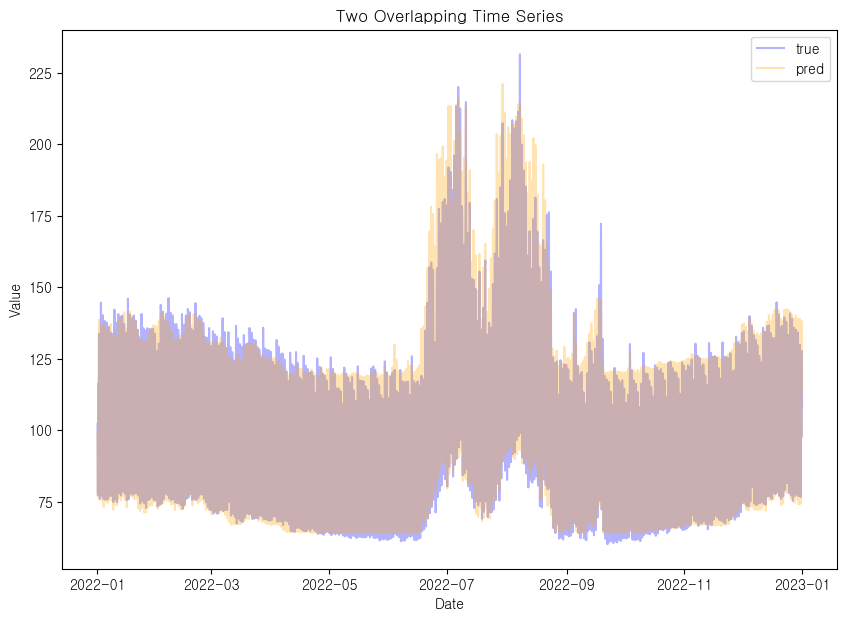

In [93]:
# 연단위로는 시계열성 예측을 잘하는 듯 보임
# 플롯 크기 설정
plt.figure(figsize=(10, 7))

# 첫 번째 시계열 데이터 플롯
plt.plot(dates, y_valid1[loca].values, label='true', color='blue', alpha = 0.3)

# 두 번째 시계열 데이터 플롯
plt.plot(dates, y_pred1[loca], label='pred', color='orange', alpha = 0.3)

# 레이블, 제목 및 범례 설정
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Two Overlapping Time Series')
plt.legend()

# 그래프 출력
plt.show()

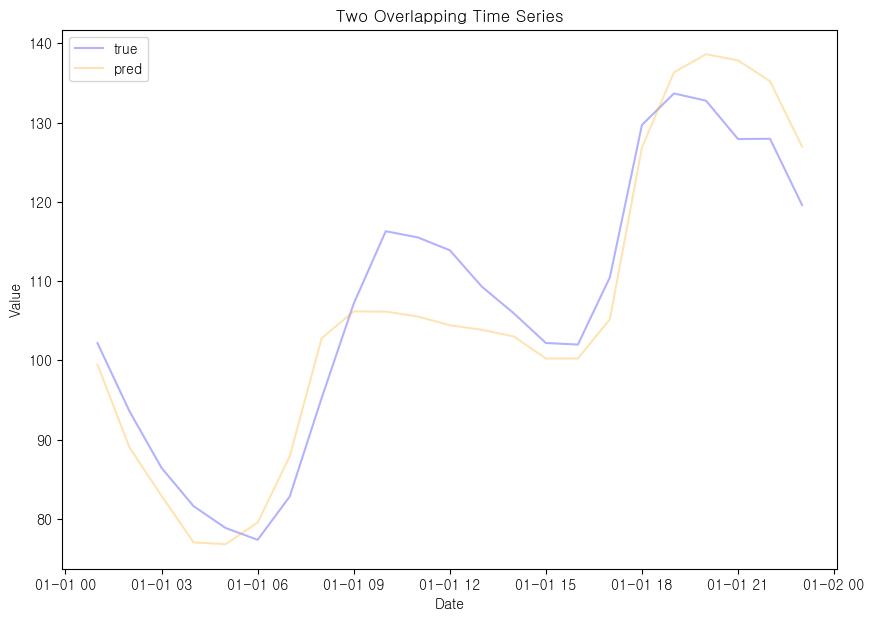

In [95]:
# 일별
# 플롯 크기 설정
plt.figure(figsize=(10, 7))

# 첫 번째 시계열 데이터 플롯
plt.plot(dates[:23], y_valid1[loca][:23].values, label='true', color='blue', alpha = 0.3)

# 두 번째 시계열 데이터 플롯
plt.plot(dates[:23], y_pred1[loca][:23], label='pred', color='orange', alpha = 0.3)

# 레이블, 제목 및 범례 설정
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Two Overlapping Time Series')
plt.legend()

# 그래프 출력
plt.show()

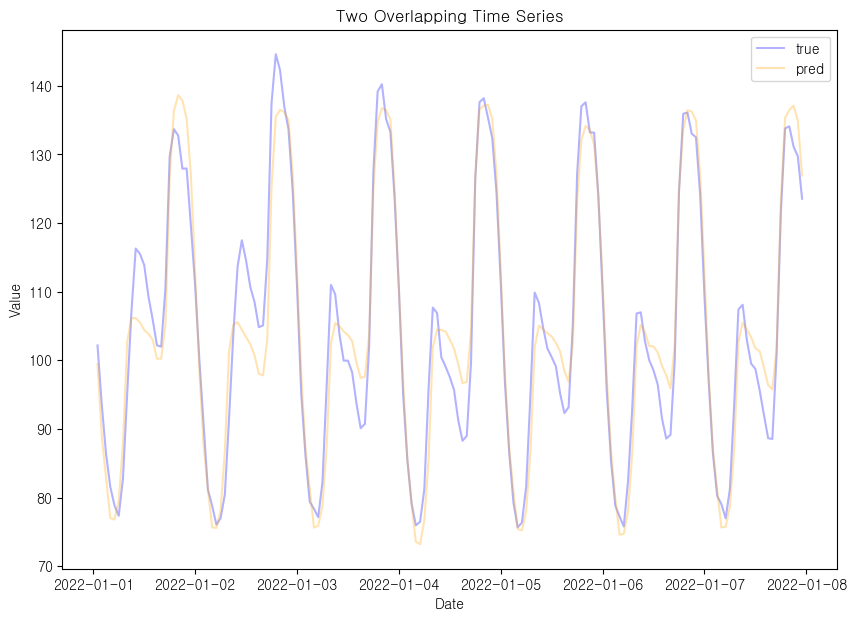

In [96]:
# 주별
# 플롯 크기 설정
plt.figure(figsize=(10, 7))

# 첫 번째 시계열 데이터 플롯
plt.plot(dates[:167], y_valid1[loca][:167].values, label='true', color='blue', alpha = 0.3)

# 두 번째 시계열 데이터 플롯
plt.plot(dates[:167], y_pred1[loca][:167], label='pred', color='orange', alpha = 0.3)

# 레이블, 제목 및 범례 설정
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Two Overlapping Time Series')
plt.legend()

# 그래프 출력
plt.show()

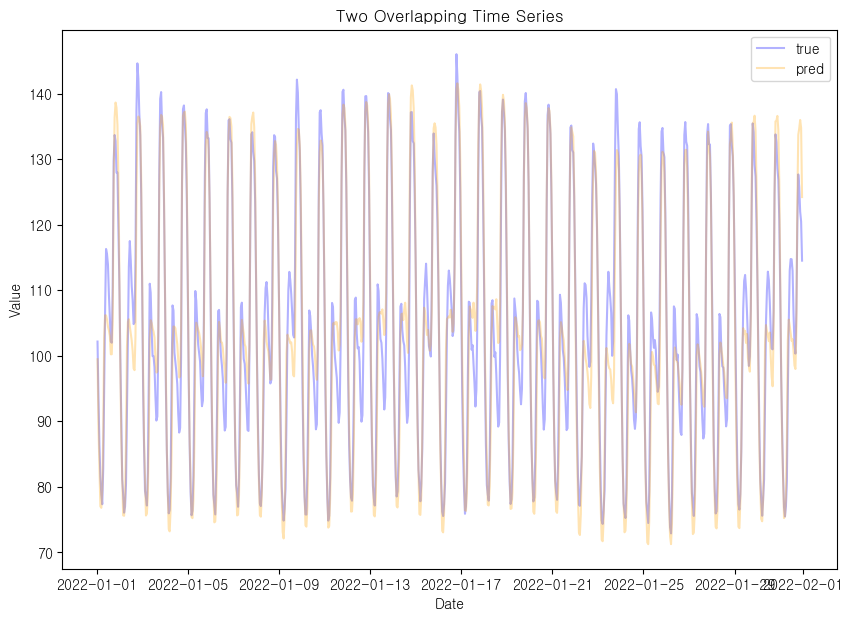

In [97]:
# 월별
# 플롯 크기 설정
plt.figure(figsize=(10, 7))

# 첫 번째 시계열 데이터 플롯
plt.plot(dates[:743], y_valid1[loca][:743].values, label='true', color='blue', alpha = 0.3)

# 두 번째 시계열 데이터 플롯
plt.plot(dates[:743], y_pred1[loca][:743], label='pred', color='orange', alpha = 0.3)

# 레이블, 제목 및 범례 설정
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Two Overlapping Time Series')
plt.legend()

# 그래프 출력
plt.show()

In [98]:
train_reseid = y_train1 - lgbm.predict(X_train1)
valid_reseid = y_valid1 - y_pred1

In [99]:
# X_train2 = train_df.drop(columns=X_train1.columns)
# X_train2 = X_train2.drop(columns=['num', 'tm', 'stn', 'elec', 'location'])
X_train2 = train_df.drop(columns=['num', 'tm', 'stn', 'elec', 'location', 'denoise_ta', 'denoise_hm', 'denoise_ws', 'denoise_ta_chi', 'sin_month', 'cos_month', 'THI'])

# X_valid2 = valid_df.drop(columns=X_valid1.columns)
# X_valid2 = X_valid2.drop(columns=['num', 'tm', 'stn', 'elec', 'location'])
X_valid2 = valid_df.drop(columns=['num', 'tm', 'stn', 'elec', 'location', 'denoise_ta', 'denoise_hm', 'denoise_ws', 'denoise_ta_chi', 'sin_month', 'cos_month', 'THI'])

In [100]:
# Catboost Regressor (이상치 포함 : 성능 안좋음)
cb = CatBoostRegressor(random_state=42, task_type = 'GPU'
                       , has_time=True)

cb.fit(X_train2, train_reseid)
y_pred2 = cb.predict(X_valid2)


Learning rate set to 0.12408
0:	learn: 6.4113967	total: 20.6ms	remaining: 20.6s
1:	learn: 6.2516954	total: 39.9ms	remaining: 19.9s
2:	learn: 6.1251660	total: 59.3ms	remaining: 19.7s
3:	learn: 6.0200918	total: 78.4ms	remaining: 19.5s
4:	learn: 5.9378479	total: 97.5ms	remaining: 19.4s
5:	learn: 5.8719422	total: 118ms	remaining: 19.5s
6:	learn: 5.8168378	total: 137ms	remaining: 19.5s
7:	learn: 5.7731800	total: 157ms	remaining: 19.5s
8:	learn: 5.7306525	total: 175ms	remaining: 19.2s
9:	learn: 5.6930677	total: 195ms	remaining: 19.3s
10:	learn: 5.6533174	total: 213ms	remaining: 19.1s
11:	learn: 5.6239222	total: 230ms	remaining: 18.9s
12:	learn: 5.5928650	total: 248ms	remaining: 18.8s
13:	learn: 5.5655422	total: 269ms	remaining: 19s
14:	learn: 5.5429241	total: 288ms	remaining: 18.9s
15:	learn: 5.5200629	total: 308ms	remaining: 18.9s
16:	learn: 5.5019693	total: 328ms	remaining: 18.9s
17:	learn: 5.4850715	total: 346ms	remaining: 18.9s
18:	learn: 5.4682515	total: 367ms	remaining: 18.9s
19:	learn

In [101]:
y_pred3 = y_pred1 + y_pred2
print('MSE:', mean_squared_error(y_valid1, y_pred3))
print('MAE:', mean_absolute_error(y_valid1, y_pred3))
print('R2:', r2_score(y_valid1, y_pred3))

MSE: 39.32594244409026
MAE: 4.365578248007125
R2: 0.9402003037110385


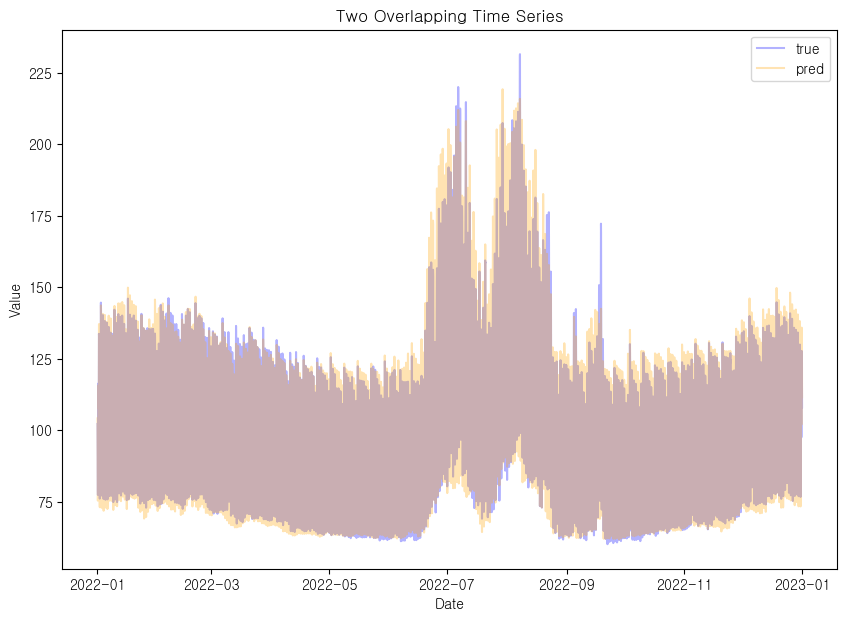

In [102]:
# 플롯 크기 설정
plt.figure(figsize=(10, 7))

# 첫 번째 시계열 데이터 플롯
plt.plot(dates, y_valid1[loca].values, label='true', color='blue', alpha = 0.3)

# 두 번째 시계열 데이터 플롯
plt.plot(dates, y_pred3[loca], label='pred', color='orange', alpha = 0.3)

# 레이블, 제목 및 범례 설정
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Two Overlapping Time Series')
plt.legend()

# 그래프 출력
plt.show()

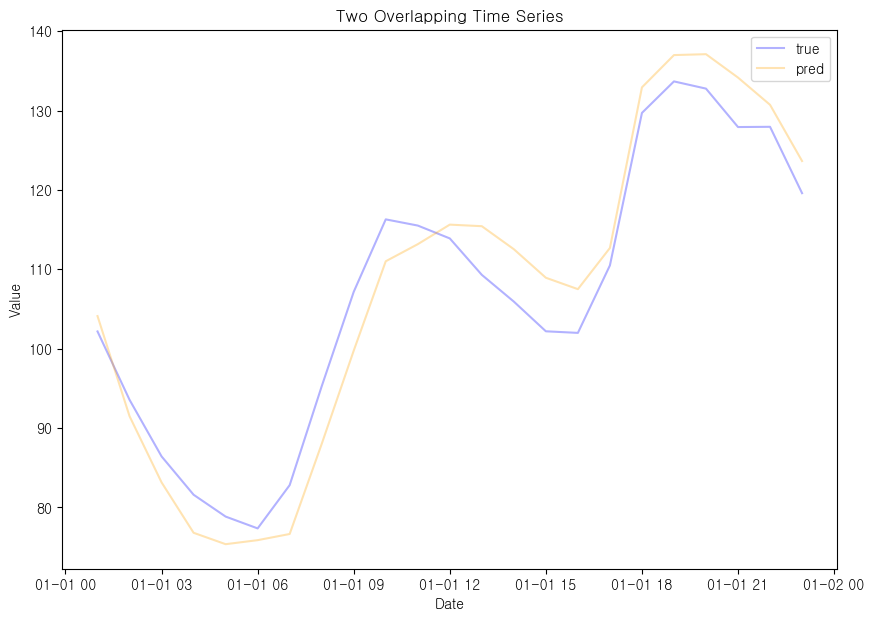

In [104]:
# 일별
# 플롯 크기 설정
plt.figure(figsize=(10, 7))

# 첫 번째 시계열 데이터 플롯
plt.plot(dates[:23], y_valid1[loca][:23].values, label='true', color='blue', alpha = 0.3)

# 두 번째 시계열 데이터 플롯
plt.plot(dates[:23], y_pred3[loca][:23], label='pred', color='orange', alpha = 0.3)

# 레이블, 제목 및 범례 설정
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Two Overlapping Time Series')
plt.legend()

# 그래프 출력
plt.show()

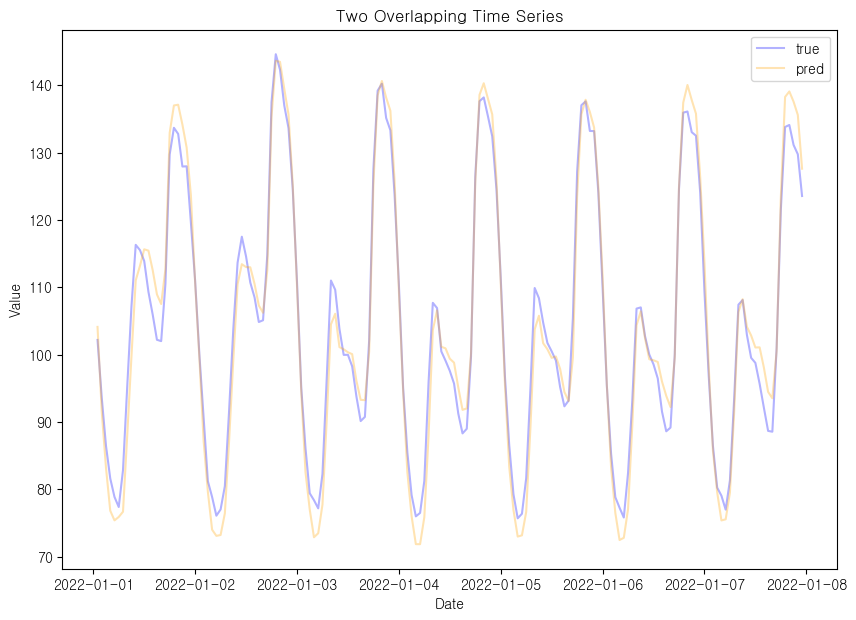

In [105]:
# 주별
# 플롯 크기 설정
plt.figure(figsize=(10, 7))

# 첫 번째 시계열 데이터 플롯
plt.plot(dates[:167], y_valid1[loca][:167].values, label='true', color='blue', alpha = 0.3)

# 두 번째 시계열 데이터 플롯
plt.plot(dates[:167], y_pred3[loca][:167], label='pred', color='orange', alpha = 0.3)

# 레이블, 제목 및 범례 설정
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Two Overlapping Time Series')
plt.legend()

# 그래프 출력
plt.show()

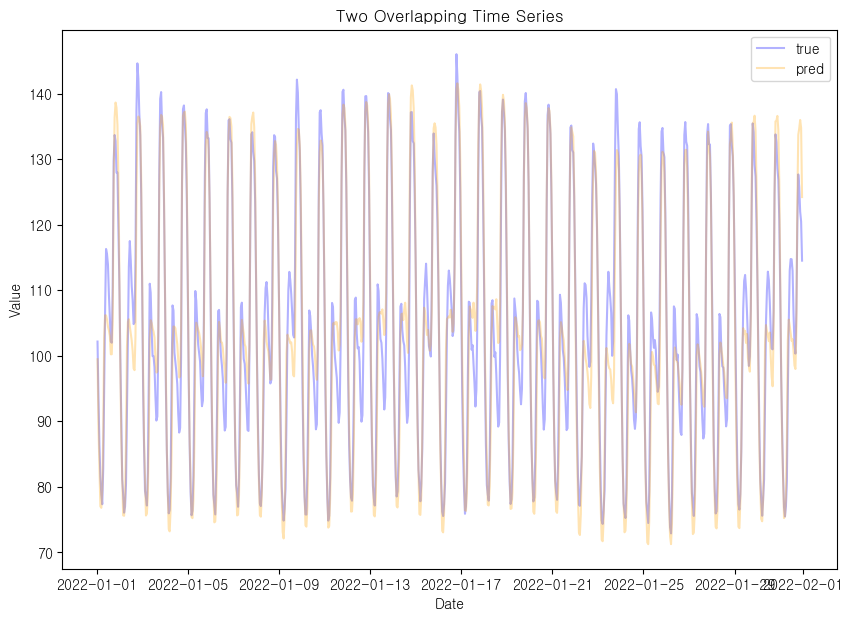

In [106]:
# 월별
# 플롯 크기 설정
plt.figure(figsize=(10, 7))

# 첫 번째 시계열 데이터 플롯
plt.plot(dates[:743], y_valid1[loca][:743].values, label='true', color='blue', alpha = 0.3)

# 두 번째 시계열 데이터 플롯
plt.plot(dates[:743], y_pred1[loca][:743], label='pred', color='orange', alpha = 0.3)

# 레이블, 제목 및 범례 설정
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Two Overlapping Time Series')
plt.legend()

# 그래프 출력
plt.show()

In [107]:
import shap

explainer = shap.TreeExplainer(lgbm) ## Explainer 객체 생성
expected_value = explainer.expected_value ## Base SHAP Value
shap_values = explainer.shap_values(X_train1) ## SHAP Value
shap_obj = explainer(X_train1)
 
print('SHAP Value :', shap_values)
print('예측값 :', y_pred1)
print('SHAP Value 합 :', np.sum(shap_values)+expected_value)

SHAP Value : [[-3.41202078e-01 -2.69530069e-02  1.29472317e-02 ...  1.09632352e-02
   2.15798581e-01 -5.00679197e-01]
 [-3.39713088e-01 -2.16960666e-02  8.46801722e-03 ...  2.08829078e-02
   2.27055621e-01 -4.32397502e-01]
 [-3.40011963e-01 -1.62047724e-02 -2.42037038e-04 ... -1.20610445e-02
   2.31749798e-01 -3.60071631e-01]
 ...
 [ 1.36372074e-01 -4.08997948e-01 -3.63817381e-02 ...  3.60099681e-02
   3.85987412e-01 -2.47289809e-01]
 [ 1.51264345e-01 -4.53989681e-01 -3.42233840e-02 ... -1.61943903e-02
   3.56296694e-01 -2.15570043e-01]
 [ 8.27907456e-02 -4.30711165e-01 -7.79965711e-03 ... -4.05487933e-02
   1.95490109e-01 -2.42214415e-01]]
예측값 : [ 93.98679924  82.52044379  76.28276705 ... 133.74132935 126.28546106
 113.97414723]
SHAP Value 합 : [99.99956614]


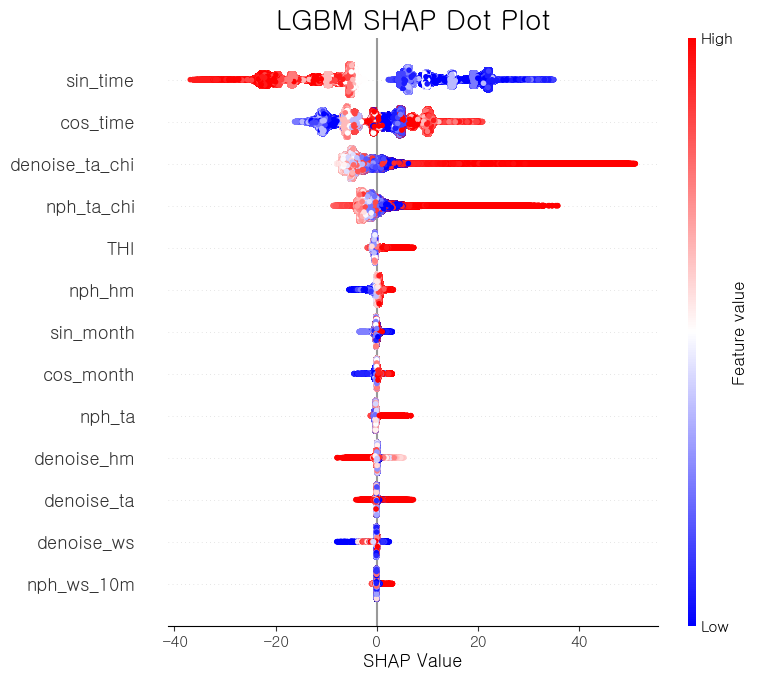

In [108]:
## Dot Plot
import matplotlib.pyplot as plt
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

plt.rcParams['axes.unicode_minus'] = False

fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
shap.summary_plot(shap_values, X_train1, 
                  feature_names=X_train1.columns, ## 변수명 표시
                  cmap='bwr', ## 컬러맵
                  show=False, ## 기존 X축 라벨 표시 안함
                 )
ax.set_xlabel('SHAP Value')
ax.set_title('LGBM SHAP Dot Plot', fontsize=20)
plt.show()

In [110]:
import shap

explainer = shap.TreeExplainer(cb) ## Explainer 객체 생성
expected_value = explainer.expected_value ## Base SHAP Value
shap_values = explainer.shap_values(X_train2) ## SHAP Value
shap_obj = explainer(X_train2)
 
print('SHAP Value :', shap_values)
print('예측값 :', y_pred2)
# print('SHAP Value 합 :', np.sum(shap_values)+expected_value)

SHAP Value : [[ 7.64800784e-01  5.64593907e-01 -1.03702602e-01 ... -1.37949394e-01
  -1.48209288e-01 -6.04642321e-05]
 [ 3.84322792e-01  5.86767905e-01 -9.56650118e-02 ... -1.34586155e-01
  -1.46801309e-01 -7.27524257e-05]
 [ 3.67385788e-01  5.86301575e-01 -4.27542495e-02 ... -1.30207083e-01
  -1.50701881e-01 -6.17561170e-05]
 ...
 [-3.66159444e-01  7.60304093e-01  2.42142273e-01 ... -1.57405007e-01
  -6.48198942e-02 -4.55594183e-05]
 [-3.52509716e-01  8.23009063e-01  2.41806811e-01 ... -1.49240674e-01
  -6.22972057e-02 -4.01165857e-05]
 [-5.79496078e-01  8.11360321e-01  3.80249982e-01 ... -5.45780674e-02
  -6.65198361e-02 -4.54543200e-05]]
예측값 : [ 6.35777598  4.89473182  2.56132623 ... -2.30992785  0.02702179
  3.84650667]


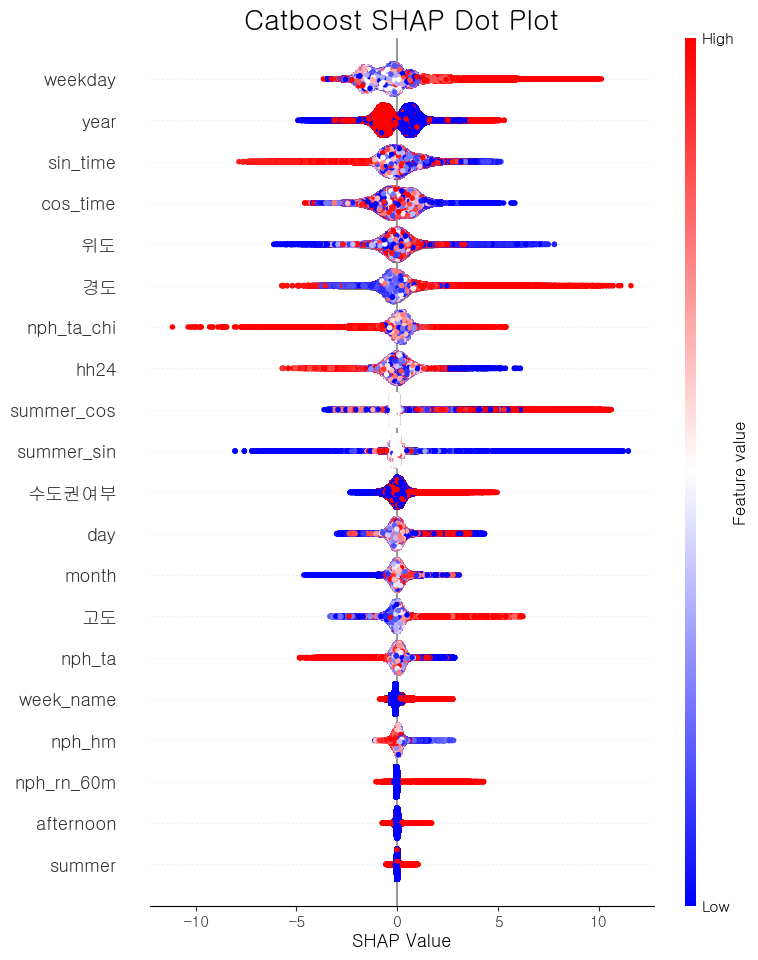

In [111]:
## Dot Plot
import matplotlib.pyplot as plt
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

plt.rcParams['axes.unicode_minus'] = False

fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
shap.summary_plot(shap_values, X_train2, 
                  feature_names=X_train2.columns, ## 변수명 표시
                  cmap='bwr', ## 컬러맵
                  show=False, ## 기존 X축 라벨 표시 안함
                 )
ax.set_xlabel('SHAP Value')
ax.set_title('Catboost SHAP Dot Plot', fontsize=20)
plt.show()

---
test 제출


In [67]:
test_df = pd.read_csv('electric_test.csv', encoding='CP949')
# test_df.drop(columns=['Unnamed: 0'], inplace=True)
test_df.columns = [col.replace('electric_test.', '') for col in test_df.columns]
# 대문자로 된 열 이름을 소문자로 변경
test_df.columns = test_df.columns.str.lower()
test_df['tm'] = pd.to_datetime(test_df['tm'])
test_df.head()


,num,tm,hh24,stn,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi,weekday,week_name,elect
0,4816,2023-01-01 01:00:00,1,752,3.0,68.6,2.9,0.0,-0.1,6,1.0,NaN
1,4816,2023-01-01 02:00:00,2,752,3.1,69.4,2.7,0.0,0.3,6,1.0,NaN
2,4816,2023-01-01 03:00:00,3,752,3.6,68.3,2.3,0.0,1.2,6,1.0,NaN
3,4816,2023-01-01 04:00:00,4,752,4.0,69.2,3.1,0.0,1.1,6,1.0,NaN
4,4816,2023-01-01 05:00:00,5,752,4.2,69.5,2.5,0.0,2.0,6,1.0,NaN


In [68]:
test_df['year'], test_df['month'], test_df['day'] = (test_df['tm'].dt.year, test_df['tm'].dt.month, test_df['tm'].dt.day)
test_df.head()

,num,tm,hh24,stn,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi,weekday,week_name,elect,year,month,day
0,4816,2023-01-01 01:00:00,1,752,3.0,68.6,2.9,0.0,-0.1,6,1.0,NaN,2023,1,1
1,4816,2023-01-01 02:00:00,2,752,3.1,69.4,2.7,0.0,0.3,6,1.0,NaN,2023,1,1
2,4816,2023-01-01 03:00:00,3,752,3.6,68.3,2.3,0.0,1.2,6,1.0,NaN,2023,1,1
3,4816,2023-01-01 04:00:00,4,752,4.0,69.2,3.1,0.0,1.1,6,1.0,NaN,2023,1,1
4,4816,2023-01-01 05:00:00,5,752,4.2,69.5,2.5,0.0,2.0,6,1.0,NaN,2023,1,1


In [69]:
# 파생변수 생성
# 1. 여름 여부
test_df['summer'] = 0
test_df.loc[(test_df['month'] >= 6) & (test_df['month'] <= 8), 'summer'] = 1
test_df

,num,tm,hh24,stn,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi,weekday,week_name,elect,year,month,day,summer
0,4816,2023-01-01 01:00:00,1,752,3.0,68.6,2.9,0.0,-0.1,6,1.0,NaN,2023,1,1,0
1,4816,2023-01-01 02:00:00,2,752,3.1,69.4,2.7,0.0,0.3,6,1.0,NaN,2023,1,1,0
2,4816,2023-01-01 03:00:00,3,752,3.6,68.3,2.3,0.0,1.2,6,1.0,NaN,2023,1,1,0
3,4816,2023-01-01 04:00:00,4,752,4.0,69.2,3.1,0.0,1.1,6,1.0,NaN,2023,1,1,0
4,4816,2023-01-01 05:00:00,5,752,4.2,69.5,2.5,0.0,2.0,6,1.0,NaN,2023,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829473,12322,2023-12-31 20:00:00,20,901,5.6,70.8,3.2,0.0,5.8,6,1.0,NaN,2023,12,31,0
2829474,12322,2023-12-31 21:00:00,21,901,5.3,69.1,3.6,0.0,4.5,6,1.0,NaN,2023,12,31,0
2829475,12322,2023-12-31 22:00:00,22,901,5.1,70.6,3.0,0.0,5.1,6,1.0,NaN,2023,12,31,0
2829476,12322,2023-12-31 23:00:00,23,901,5.2,69.7,3.8,0.0,5.1,6,1.0,NaN,2023,12,31,0


In [70]:
# valid에도 똑같이 전처리!
# 위도 및 경도 변수 생성
# location 데이터프레임에서 중복되는 지점 중 가장 마지막 값을 유지
test_df = pd.merge(test_df, merged_aws[['AWS', '경도', '위도', '고도', 'location', 'mountain']], left_on='stn', right_on='AWS', how='left')

# 필요 없는 열 제거
test_df.drop(columns=['AWS'], inplace=True)

# 각 AWS의 위도와 경도를 동일하게 설정
# merged_df['위도'] = merged_df.groupby('AWS')['위도'].transform('last')
# merged_df['경도'] = merged_df.groupby('AWS')['경도'].transform('last')

# 결과 출력
test_df


,num,tm,hh24,stn,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi,weekday,...,elect,year,month,day,summer,경도,위도,고도,location,mountain
0,4816,2023-01-01 01:00:00,1,752,3.0,68.6,2.9,0.0,-0.1,6,...,NaN,2023,1,1,0,126.3022,33.2850,188.0,제주,0.0
1,4816,2023-01-01 02:00:00,2,752,3.1,69.4,2.7,0.0,0.3,6,...,NaN,2023,1,1,0,126.3022,33.2850,188.0,제주,0.0
2,4816,2023-01-01 03:00:00,3,752,3.6,68.3,2.3,0.0,1.2,6,...,NaN,2023,1,1,0,126.3022,33.2850,188.0,제주,0.0
3,4816,2023-01-01 04:00:00,4,752,4.0,69.2,3.1,0.0,1.1,6,...,NaN,2023,1,1,0,126.3022,33.2850,188.0,제주,0.0
4,4816,2023-01-01 05:00:00,5,752,4.2,69.5,2.5,0.0,2.0,6,...,NaN,2023,1,1,0,126.3022,33.2850,188.0,제주,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829473,12322,2023-12-31 20:00:00,20,901,5.6,70.8,3.2,0.0,5.8,6,...,NaN,2023,12,31,0,129.4424,35.4927,68.0,울산,0.0
2829474,12322,2023-12-31 21:00:00,21,901,5.3,69.1,3.6,0.0,4.5,6,...,NaN,2023,12,31,0,129.4424,35.4927,68.0,울산,0.0
2829475,12322,2023-12-31 22:00:00,22,901,5.1,70.6,3.0,0.0,5.1,6,...,NaN,2023,12,31,0,129.4424,35.4927,68.0,울산,0.0
2829476,12322,2023-12-31 23:00:00,23,901,5.2,69.7,3.8,0.0,5.1,6,...,NaN,2023,12,31,0,129.4424,35.4927,68.0,울산,0.0


In [71]:
seoul_OX = ['서울', '경기', '인천']
test_df['수도권여부'] = 0
test_df.loc[test_df['location'].isin(seoul_OX), '수도권여부'] = 1
# train_df.drop(columns=['location'], inplace=True)
test_df

,num,tm,hh24,stn,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi,weekday,...,year,month,day,summer,경도,위도,고도,location,mountain,수도권여부
0,4816,2023-01-01 01:00:00,1,752,3.0,68.6,2.9,0.0,-0.1,6,...,2023,1,1,0,126.3022,33.2850,188.0,제주,0.0,0
1,4816,2023-01-01 02:00:00,2,752,3.1,69.4,2.7,0.0,0.3,6,...,2023,1,1,0,126.3022,33.2850,188.0,제주,0.0,0
2,4816,2023-01-01 03:00:00,3,752,3.6,68.3,2.3,0.0,1.2,6,...,2023,1,1,0,126.3022,33.2850,188.0,제주,0.0,0
3,4816,2023-01-01 04:00:00,4,752,4.0,69.2,3.1,0.0,1.1,6,...,2023,1,1,0,126.3022,33.2850,188.0,제주,0.0,0
4,4816,2023-01-01 05:00:00,5,752,4.2,69.5,2.5,0.0,2.0,6,...,2023,1,1,0,126.3022,33.2850,188.0,제주,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829473,12322,2023-12-31 20:00:00,20,901,5.6,70.8,3.2,0.0,5.8,6,...,2023,12,31,0,129.4424,35.4927,68.0,울산,0.0,0
2829474,12322,2023-12-31 21:00:00,21,901,5.3,69.1,3.6,0.0,4.5,6,...,2023,12,31,0,129.4424,35.4927,68.0,울산,0.0,0
2829475,12322,2023-12-31 22:00:00,22,901,5.1,70.6,3.0,0.0,5.1,6,...,2023,12,31,0,129.4424,35.4927,68.0,울산,0.0,0
2829476,12322,2023-12-31 23:00:00,23,901,5.2,69.7,3.8,0.0,5.1,6,...,2023,12,31,0,129.4424,35.4927,68.0,울산,0.0,0


In [72]:
# 시간 변수 생성 : 시간
test_df['sin_time'] = np.sin(2 * np.pi * test_df['hh24'] / 24)
test_df['cos_time'] = np.cos(2 * np.pi * test_df['hh24'] / 24)

In [73]:
# 시간 변수 생성 : 월
test_df['sin_month'] = np.sin(2 * np.pi * test_df['month'] / 12)
test_df['cos_month'] = np.cos(2 * np.pi * test_df['month'] / 12)

In [74]:
# 오후 여부 변수 추가
test_df['afternoon'] = 0
test_df.loc[(test_df['hh24'] >= 12)&(test_df['hh24'] <= 15), 'afternoon'] = 1

In [75]:
test_df['summer_cos'] = 0
test_df.loc[(test_df['summer'] == 1), 'summer_cos'] = summer_cos(test_df.loc[(test_df['summer'] == 1), 'tm'])

In [76]:
test_df['summer_sin'] = 0
test_df.loc[(test_df['summer'] == 1), 'summer_sin'] = summer_sin(test_df.loc[(test_df['summer'] == 1), 'tm'])

푸리에 변환을 통해 노이즈 제거

In [77]:
def denoise_fft(data, ifftn):
    # Fast Fourier Transformation
    fft_signal = np.fft.fft(data)
    
    # Reconstruct Original Signal
    fft_signal[ifftn:len(fft_signal)//2]=0
    fft_signal[len(fft_signal)//2:-ifftn]=0
    reconstructed_signal = np.fft.ifft(fft_signal)
    
    return reconstructed_signal.real

In [78]:
test_df['denoise_hm'] = 0
for num in test_df['num'].unique():
    test_df.loc[test_df['num'] == num, 'denoise_hm'] = denoise_fft(data = test_df.loc[test_df['num'] == num, 'nph_hm'], ifftn=30)    

In [79]:
test_df['denoise_ta'] = 0
for num in test_df['num'].unique():
    test_df.loc[test_df['num'] == num, 'denoise_ta'] = denoise_fft(data = test_df.loc[test_df['num'] == num, 'nph_ta'], ifftn=15)    

In [80]:
test_df['denoise_ws'] = 0
for num in test_df['num'].unique():
    test_df.loc[test_df['num'] == num, 'denoise_ws'] = denoise_fft(data = test_df.loc[test_df['num'] == num, 'nph_ws_10m'], ifftn=50)    

In [81]:
test_df['denoise_ta_chi'] = 0
for num in test_df['num'].unique():
    test_df.loc[test_df['num'] == num, 'denoise_ta_chi'] = denoise_fft(data = test_df.loc[test_df['num'] == num, 'nph_ta_chi'], ifftn=25)    

In [82]:
# 불쾌지수 모델링
test_df['THI'] = 9/5*test_df['nph_ta'] - 0.55*(1-test_df['nph_hm']/100)*(9/5*test_df['nph_hm']-26)+32

test_df['불쾌여부'] = 0
test_df.loc[test_df['THI'] >= 80, '불쾌여부'] = 1

In [83]:
X_test1 = test_df[['nph_ta', 'nph_hm', 'nph_ws_10m', 'nph_ta_chi', 'denoise_ta', 'denoise_hm', 'denoise_ws', 'denoise_ta_chi', 'sin_time', 'cos_time', 'sin_month', 'cos_month', 'THI']]

In [84]:
# LGBM 모델링
lgbm = LGBMRegressor(random_state=42, device = 'gpu')
lgbm.fit(pd.concat([X_train1, X_valid1]), pd.concat([y_train1, y_valid1]))
y_pred1 = lgbm.predict(X_test1)

In [85]:
resid = pd.concat([y_train1, y_valid1]) - lgbm.predict(pd.concat([X_train1, X_valid1]))

In [86]:
X_test2 = test_df.drop(columns=['num', 'tm', 'stn', 'elect', 'location', 'denoise_ta', 'denoise_hm', 'denoise_ws', 'denoise_ta_chi', 'sin_month', 'cos_month', 'THI'])

In [87]:
pd.concat([X_train2, X_valid2])

,hh24,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi,weekday,week_name,year,month,...,위도,고도,mountain,수도권여부,sin_time,cos_time,afternoon,summer_cos,summer_sin,불쾌여부
0,1,2.2,62.7,1.8,0.0,-1.0,4,0,2021,1,...,33.2593,173.0,0,0,2.588190e-01,0.965926,0,0.0,0.0,0
1,2,2.3,63.1,2.1,0.0,-0.6,4,0,2021,1,...,33.2593,173.0,0,0,5.000000e-01,0.866025,0,0.0,0.0,0
2,3,2.2,62.4,2.5,0.0,-1.3,4,0,2021,1,...,33.2593,173.0,0,0,7.071068e-01,0.707107,0,0.0,0.0,0
3,4,1.7,63.5,1.7,0.0,-0.2,4,0,2021,1,...,33.2593,173.0,0,0,8.660254e-01,0.500000,0,0.0,0.0,0
4,5,1.7,63.0,1.6,0.0,-0.8,4,0,2021,1,...,33.2593,173.0,0,0,9.659258e-01,0.258819,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2338913,20,2.7,46.3,3.1,0.0,-0.4,5,1,2022,12,...,38.1988,4.0,0,0,-8.660254e-01,0.500000,0,0.0,0.0,0
2338914,21,2.6,46.8,3.1,0.0,-0.5,5,1,2022,12,...,38.1988,4.0,0,0,-7.071068e-01,0.707107,0,0.0,0.0,0
2338915,22,2.4,47.4,2.1,0.0,0.2,5,1,2022,12,...,38.1988,4.0,0,0,-5.000000e-01,0.866025,0,0.0,0.0,0
2338916,23,2.5,47.0,2.1,0.0,0.3,5,1,2022,12,...,38.1988,4.0,0,0,-2.588190e-01,0.965926,0,0.0,0.0,0


In [88]:
# Catboost Regressor
cb = CatBoostRegressor(random_state=42, task_type = 'GPU'
                       , has_time=True)

cb.fit(pd.concat([X_train2, X_valid2]), resid)
y_pred2 = cb.predict(X_test2)


Learning rate set to 0.130211
0:	learn: 6.6723877	total: 32.8ms	remaining: 32.8s
1:	learn: 6.5025405	total: 64.9ms	remaining: 32.4s
2:	learn: 6.3659513	total: 96.4ms	remaining: 32s
3:	learn: 6.2551853	total: 128ms	remaining: 31.9s
4:	learn: 6.1686613	total: 159ms	remaining: 31.6s
5:	learn: 6.0977729	total: 190ms	remaining: 31.5s
6:	learn: 6.0416696	total: 223ms	remaining: 31.6s
7:	learn: 5.9955188	total: 255ms	remaining: 31.6s
8:	learn: 5.9425357	total: 285ms	remaining: 31.3s
9:	learn: 5.9091987	total: 317ms	remaining: 31.4s
10:	learn: 5.8682747	total: 347ms	remaining: 31.2s
11:	learn: 5.8440806	total: 378ms	remaining: 31.1s
12:	learn: 5.8167361	total: 406ms	remaining: 30.9s
13:	learn: 5.7898152	total: 435ms	remaining: 30.7s
14:	learn: 5.7711364	total: 465ms	remaining: 30.5s
15:	learn: 5.7474109	total: 498ms	remaining: 30.6s
16:	learn: 5.7247695	total: 529ms	remaining: 30.6s
17:	learn: 5.7076266	total: 563ms	remaining: 30.7s
18:	learn: 5.6857136	total: 596ms	remaining: 30.8s
19:	learn:

In [89]:
test = pd.read_csv('electric_test.csv', encoding='CP949')
test['elect'] = y_pred1 + y_pred2
test

,NUM,TM,HH24,STN,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi,weekday,week_name,elect
0,4816,2023-01-01 01:00:00,1,752,3.0,68.6,2.9,0.0,-0.1,6,1.0,97.259384
1,4816,2023-01-01 02:00:00,2,752,3.1,69.4,2.7,0.0,0.3,6,1.0,85.336173
2,4816,2023-01-01 03:00:00,3,752,3.6,68.3,2.3,0.0,1.2,6,1.0,77.214296
3,4816,2023-01-01 04:00:00,4,752,4.0,69.2,3.1,0.0,1.1,6,1.0,72.192618
4,4816,2023-01-01 05:00:00,5,752,4.2,69.5,2.5,0.0,2.0,6,1.0,70.955858
...,...,...,...,...,...,...,...,...,...,...,...,...
2829473,12322,2023-12-31 20:00:00,20,901,5.6,70.8,3.2,0.0,5.8,6,1.0,134.978116
2829474,12322,2023-12-31 21:00:00,21,901,5.3,69.1,3.6,0.0,4.5,6,1.0,133.582544
2829475,12322,2023-12-31 22:00:00,22,901,5.1,70.6,3.0,0.0,5.1,6,1.0,129.180207
2829476,12322,2023-12-31 23:00:00,23,901,5.2,69.7,3.8,0.0,5.1,6,1.0,118.845545


In [90]:
test.to_csv('240555.csv', index = False)